In [34]:
# Cell 1: Imports and simulation settings
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Brian2 settings
defaultclock.dt = 0.1*ms
prefs.codegen.target = 'numpy'

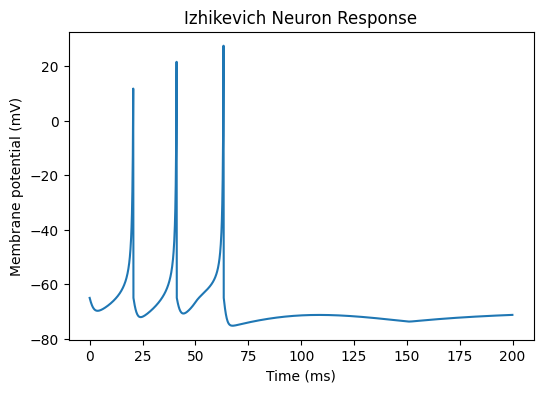

In [35]:
# Cell 2: Izhikevich neuron equations and parameters
# Define Izhikevich parameters
a = 0.02/ms
b = 0.2/ms
c = -65*mV
d = 8*mV/ms

izh_eqs = '''
 dv/dt = (0.04/ms/mV)*v**2 + (5/ms)*v + 140*mV/ms - u + I_ext : volt
 du/dt = a*(b*v - u)                                           : volt/second
 I_ext : volt/second
'''

# Create neuron group
N = 1
izhi = NeuronGroup(N, model=izh_eqs, threshold='v>30*mV', reset='v = c; u += d', method='euler')
izhi.v = c
izhi.u = b * izhi.v

# Define step current profile in ms and amplitude
times_ms = np.array([0, 50, 150])  # in milliseconds
I_amplitudes = np.array([0, 15, 0])  # in mV/ms units

@network_operation(dt=defaultclock.dt)
def apply_current():
    t_ms = float(defaultclock.t / ms)
    # Interpolate amplitude at current time
    amp = np.interp(t_ms, times_ms, I_amplitudes) * mV/ms
    izhi.I_ext = amp

# Monitors and run
statemon_izhi = StateMonitor(izhi, 'v', record=True)
# Create explicit network to avoid magic mix-up
net_izhi = Network(izhi, apply_current, statemon_izhi)
net_izhi.run(200*ms)

# Plot
plt.figure(figsize=(6,4))
plt.plot(statemon_izhi.t/ms, statemon_izhi.v[0]/mV)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Izhikevich Neuron Response')
plt.show()

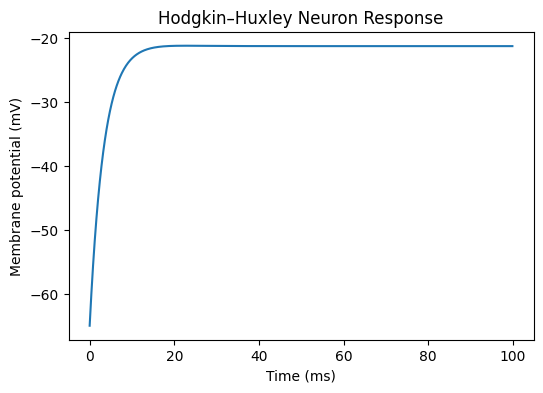

In [36]:
# Cell 3: Hodgkin-Huxley equations with current density
# Define HH equations: I_ext is current density (amp/meter**2)
eqs_hh = '''
 dv/dt = (I_ext - g_na*m**3*h*(v-E_na) - g_k*n**4*(v-E_k) - g_l*(v-E_l))/C_m : volt
 dm/dt = alpha_m*(1-m) - beta_m*m                                   : 1
 dh/dt = alpha_h*(1-h) - beta_h*h                                   : 1
 dn/dt = alpha_n*(1-n) - beta_n*n                                   : 1
 I_ext : amp/meter**2
 alpha_m = 0.1*(mV**-1)*(25*mV - v)/(exp((25*mV - v)/(10*mV)) - 1)/ms    : Hz
 beta_m = 4*exp(-v/(18*mV))/ms                                            : Hz
 alpha_h = 0.07*exp(-v/(20*mV))/ms                                        : Hz
 beta_h = 1/(exp((30*mV - v)/(10*mV)) + 1)/ms                              : Hz
 alpha_n = 0.01*(mV**-1)*(10*mV - v)/(exp((10*mV - v)/(10*mV)) - 1)/ms      : Hz
 beta_n = 0.125*exp(-v/(80*mV))/ms                                         : Hz
 C_m = 1*ufarad/cm**2                                                      : farad/meter**2
 g_na = 120*msiemens/cm**2                                                 : siemens/meter**2
 g_k = 36*msiemens/cm**2                                                   : siemens/meter**2
 g_l = 0.3*msiemens/cm**2                                                  : siemens/meter**2
 E_na = 50*mV                                                               : volt
 E_k = -77*mV                                                               : volt
 E_l = -54.4*mV                                                             : volt
'''

# Create and simulate
group_hh = NeuronGroup(1, model=eqs_hh, method='exponential_euler', threshold='v>0*mV', refractory=3*ms)
# Initial states
group_hh.v = -65*mV
group_hh.m = 'alpha_m/(alpha_m+beta_m)'
group_hh.h = 'alpha_h/(alpha_h+beta_h)'
group_hh.n = 'alpha_n/(alpha_n+beta_n)'

# Apply a constant current density of 10 uA/cm2
group_hh.I_ext = 10*uA/cm**2

# Monitor and run
mon_hh = StateMonitor(group_hh, 'v', record=0)
net_hh = Network(group_hh, mon_hh)
net_hh.run(100*ms)

# Plot Hodgkin-Huxley response
plt.figure(figsize=(6,4))
plt.plot(mon_hh.t/ms, mon_hh.v[0]/mV)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Hodgkin–Huxley Neuron Response')
plt.show()

In [37]:
N_E = 800
N_I = 200

# Define Izhikevich populations
E_group = NeuronGroup(N_E, model=izh_eqs, threshold='v>30*mV', reset='v=c; u+=d', method='euler')
I_group = NeuronGroup(N_I, model=izh_eqs, threshold='v>30*mV', reset='v=c; u+=d', method='euler')
E_group.v = c; E_group.u = b*c
I_group.v = c; I_group.u = b*c

# External Poisson input
grate = 30*Hz
P_input = PoissonGroup(N_E, rates=grate)

In [38]:
tau_pre = tau_post = 20*ms
A_pre = 0.01
A_post = -A_pre * tau_pre/tau_post * 1.05
w_max = 1.0

EE = Synapses(E_group, E_group,
              model='''
              w : 1
              dapre/dt = -apre/tau_pre : 1 (event-driven)
              dapost/dt = -apost/tau_post : 1 (event-driven)
              ''',
              on_pre='''v_post += w*mV
                         apre += A_pre
                         w = clip(w, 0, w_max)''',
              on_post='''apost += A_post
                          w = clip(w, 0, w_max)''')
EE.connect(p=0.02)
EE.w = 'rand()*w_max'

# E->I, I->E, I->I static
gEI = Synapses(E_group, I_group, on_pre='v_post += 0.5*mV')
gEI.connect(p=0.02)
gIE = Synapses(I_group, E_group, on_pre='v_post -= 1*mV')
gIE.connect(p=0.02)
gII = Synapses(I_group, I_group, on_pre='v_post -= 1*mV')
gII.connect(p=0.02)

# Poisson input to E

inp = Synapses(P_input, E_group, on_pre='v_post += 3*mV')
inp.connect(j='i')

WARNING    'i' is an internal variable of group 'synapses_9', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [39]:
events = SpikeMonitor(E_group)
volt_mon = StateMonitor(E_group, 'v', record=range(5))
# Explicit network with all components
net2 = Network(E_group, I_group, P_input, EE, gEI, gIE, gII, inp, events, volt_mon)
net2.run(1*second)

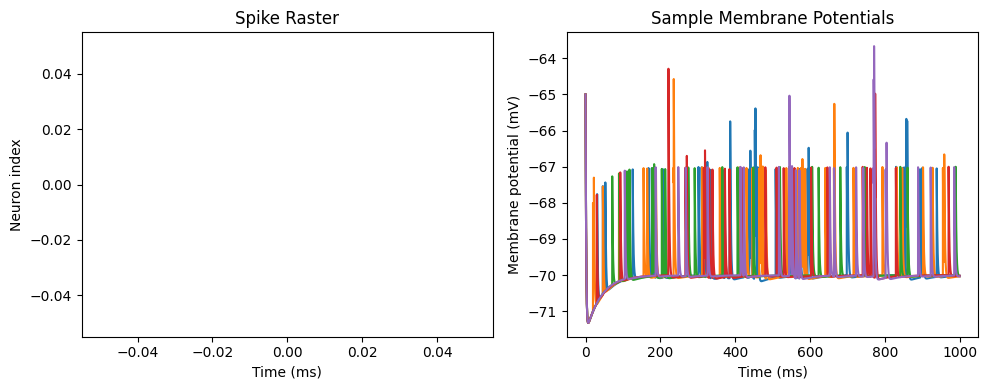

In [40]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(events.t/ms, events.i, ',k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Spike Raster')

plt.subplot(122)
for i in range(5):
    plt.plot(volt_mon.t/ms, volt_mon.v[i]/mV)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Sample Membrane Potentials')

plt.tight_layout()
plt.show()